In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,  accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

### Ennustukset parhaalla mallilla käyttäen testidataa

In [2]:
datagen_test_eval = ImageDataGenerator(rescale=1./255)
test_eval_generator = datagen_test_eval.flow_from_directory('./data/test_eval',target_size=(96, 96), class_mode='binary', batch_size=10, shuffle=False)

Found 22017 images belonging to 2 classes.


In [6]:
best_model_path = "models_20221023T2328/models/2_v1.hdf5"

In [4]:
model = load_model(best_model_path)
X_test_eval = np.concatenate([test_eval_generator .next()[0] for i in range(test_eval_generator .__len__())])
y_test_eval = np.concatenate([test_eval_generator .next()[1] for i in range(test_eval_generator .__len__())])

preds = model.predict(X_test_eval, batch_size=10)

In [5]:
preds_labels = (preds > 0.50).astype(int)[:,0]

In [6]:
tn, fp, fn, tp = confusion_matrix(y_test_eval, preds_labels).ravel()
acc, prec, rec, fscore = accuracy_score(y_test_eval, preds_labels), precision_score(y_test_eval, preds_labels), recall_score(y_test_eval, preds_labels), f1_score(y_test_eval, preds_labels)

title = f'Classification results: \n TP: {tp}, TN: {tn}, FN: {fn}, FP: {fp} \n ACC: {acc:.5f}, PREC: {prec:.5f}, REC: {rec:.5f}, FSCORE: {fscore:.5f} \n'

In [8]:
print(title)

Classification results: 
 TP: 12490, TN: 7914, FN: 671, FP: 942 
 ACC: 0.92674, PREC: 0.92987, REC: 0.94902, FSCORE: 0.93934 



In [18]:
def plot_confusion_matrix(actual, predicted):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.0)
  ax.set_title('Confusion matrix')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  labels = ["non-cancerous","cancerous"]
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)


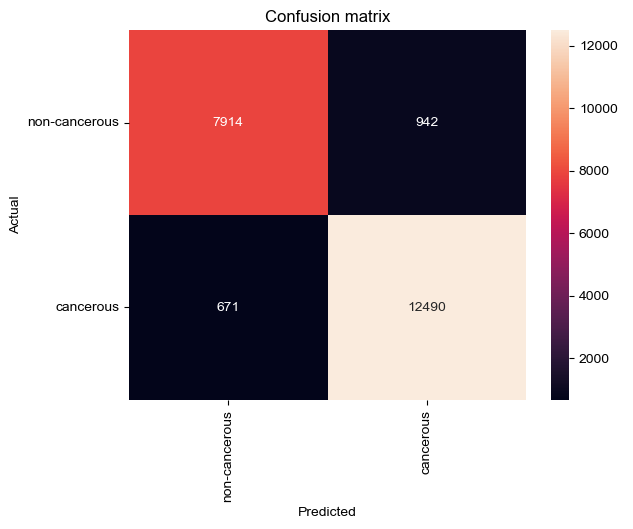

In [10]:
plot_confusion_matrix(y_test_eval, preds_labels)

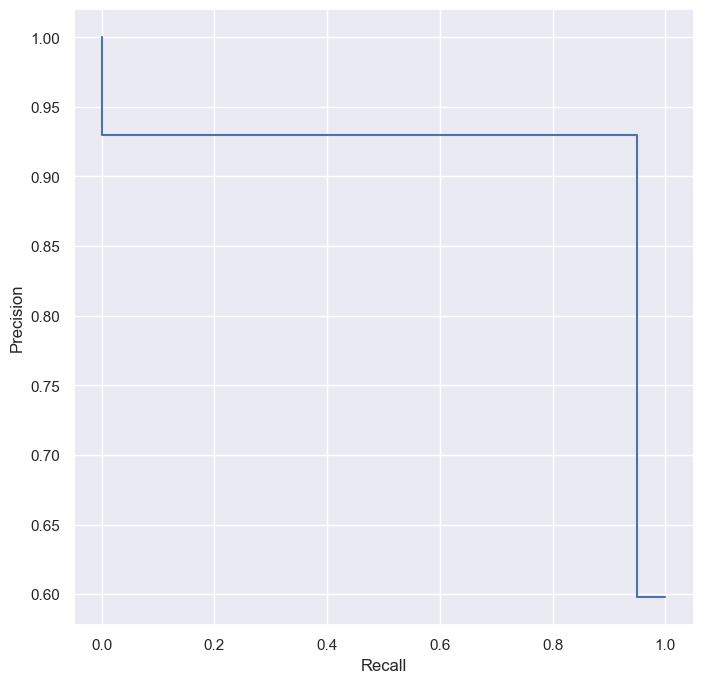

In [11]:
precision, recall, thresholds = precision_recall_curve(y_test_eval, preds_labels)
prd = PrecisionRecallDisplay(precision, recall)
prd.plot()

In [12]:
f1_scores = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  1
Best F1-Score:  0.939344940397849


### Lopulliset ennustukset testidatalla

In [12]:
datagen_unseen = ImageDataGenerator(rescale=1./255)
unseen_generator = datagen_unseen.flow_from_directory('./data/unseen',target_size=(96, 96), class_mode='binary', batch_size=10, shuffle=False)

Found 21717 images belonging to 2 classes.


In [13]:
with tf.device('/cpu:0'):
    X_unseen = np.concatenate([unseen_generator .next()[0] for i in range(unseen_generator .__len__())])
    y_unseen = np.concatenate([unseen_generator .next()[1] for i in range(unseen_generator .__len__())])

    preds = model.predict(X_unseen, batch_size=10)

In [14]:
preds_labels = (preds > 0.5).astype(int)[:,0]

In [15]:
tn, fp, fn, tp = confusion_matrix(y_unseen, preds_labels).ravel()
acc, prec, rec, fscore = accuracy_score(y_unseen, preds_labels), precision_score(y_unseen, preds_labels), recall_score(y_unseen, preds_labels), f1_score(y_unseen, preds_labels)

title = f'Classification results: \n TP: {tp}, TN: {tn}, FN: {fn}, FP: {fp} \n ACC: {acc:.5f}, PREC: {prec:.5f}, REC: {rec:.5f}, FSCORE: {fscore:.5f} \n'

In [16]:
print(title)

Classification results: 
 TP: 12185, TN: 7934, FN: 660, FP: 938 
 ACC: 0.92642, PREC: 0.92852, REC: 0.94862, FSCORE: 0.93846 



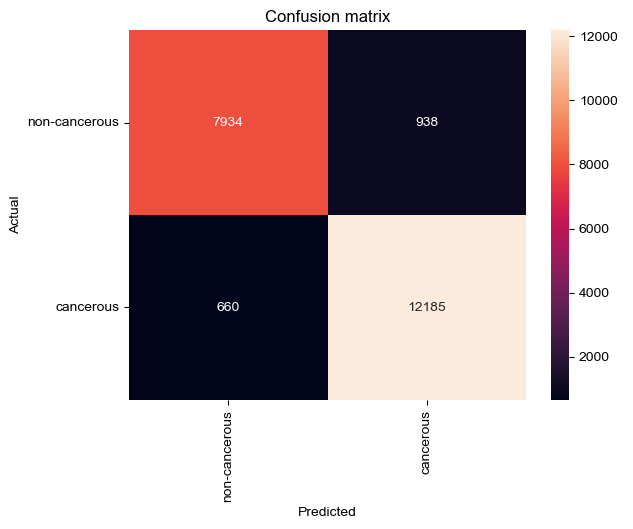

In [19]:
plot_confusion_matrix(y_unseen, preds_labels)

### Kaikkien laajojen ajojen mallien tarkkuudet

In [5]:
non_limited_model_paths = ["models_20221023T2328/models", "models_20221028T1838/models"]
with tf.device('/cpu:0'):
    for model_path in non_limited_model_paths:
        for file in os.listdir(model_path):
            model = load_model(os.path.sep.join([model_path, file]))
            preds = model.predict(X_unseen, batch_size=10)
            preds_labels = (preds > 0.50).astype(int)[:,0]
        
            tn, fp, fn, tp = confusion_matrix(y_unseen, preds_labels).ravel()
            acc, prec, rec, fscore = accuracy_score(y_unseen, preds_labels), precision_score(y_unseen, preds_labels), recall_score(y_unseen, preds_labels), f1_score(y_unseen, preds_labels)

            print(f'{os.path.sep.join([model_path, file])}: classification results: \n TP: {tp}, TN: {tn}, FN: {fn}, FP: {fp} \n ACC: {acc:.5f}, PREC: {prec:.5f}, REC: {rec:.5f}, FSCORE: {fscore:.5f} \n')

gs_dnn_ensemble_20221023T2328/models\1_v1.hdf5: classification results: 
 TP: 12179, TN: 7745, FN: 666, FP: 1127 
 ACC: 0.91744, PREC: 0.91530, REC: 0.94815, FSCORE: 0.93144 

gs_dnn_ensemble_20221023T2328/models\1_v2.hdf5: classification results: 
 TP: 12316, TN: 7733, FN: 529, FP: 1139 
 ACC: 0.92319, PREC: 0.91535, REC: 0.95882, FSCORE: 0.93658 

gs_dnn_ensemble_20221023T2328/models\2_v1.hdf5: classification results: 
 TP: 12185, TN: 7934, FN: 660, FP: 938 
 ACC: 0.92642, PREC: 0.92852, REC: 0.94862, FSCORE: 0.93846 

gs_dnn_ensemble_20221023T2328/models\2_v2.hdf5: classification results: 
 TP: 12450, TN: 7362, FN: 395, FP: 1510 
 ACC: 0.91228, PREC: 0.89183, REC: 0.96925, FSCORE: 0.92893 

gs_dnn_ensemble_20221023T2328/models\3_v1.hdf5: classification results: 
 TP: 12150, TN: 7653, FN: 695, FP: 1219 
 ACC: 0.91187, PREC: 0.90882, REC: 0.94589, FSCORE: 0.92699 

gs_dnn_ensemble_20221023T2328/models\3_v2.hdf5: classification results: 
 TP: 12025, TN: 7681, FN: 820, FP: 1191 
 ACC: 0

### Kaggle submission tiedoston generointi
Koska kyseessä on Kagglen tarjoama datasetti on hyvä käyttää myös sen tarjoamia metriikoita tulosten varmentamiseen

In [7]:
kaggle_eval = ImageDataGenerator(rescale=1./255)
kaggle_eval_generator = kaggle_eval.flow_from_directory('./data/kaggle',target_size=(96, 96), class_mode='categorical', batch_size=1, shuffle=False)

Found 57458 images belonging to 1 classes.


In [8]:
model = load_model(best_model_path)
preds = model.predict(kaggle_eval_generator, batch_size=10)

In [9]:
submission = pd.DataFrame([str(filename).removeprefix('test_images\\').replace('.tif', '') for filename in kaggle_eval_generator.filenames], columns=['id']).set_index('id')
submission['label'] = [1-pred[0] for pred in preds] #Kaggle haluaa tämän binääriennustuksen toisinpäin
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.992053
0000ec92553fda4ce39889f9226ace43cae3364e,0.787201
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.928604
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.149921
000270442cc15af719583a8172c87cd2bd9c7746,0.005316


In [10]:
submission.to_csv('kaggle_submission.csv')

#### Kagglen antamat pisteet private score: 0.921 ja public score: 0.9468